# Clustering of Precipitation Data in Boyacá

This notebook performs clustering analysis for precipitation and elevation data in the region of Boyacá, Colombia.

## Contents:
Environment setup (local and Colab compatible) 2.
2. Clustering analysis by elevation
3. Precipitation analysis by elevation level
4. Clustering of monthly precipitation patterns
5. Visualization of monthly clusters

In [1]:
# =============== ENVIRONMENT CONFIGURATION (LOCAL/COLAB) ===============
import os
import sys
from pathlib import Path

# Detect if we are in Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # If we are in Colab, configure corresponding routes
    !pip install -q xarray netCDF4 numpy matplotlib sklearn pandas geopandas fiona shapely
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # If we are in local, use the project path
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Environment configured. Project base path: {BASE_PATH}")

# Define data paths
DATA_PATH = BASE_PATH / 'data' / 'output'
SHAPES_PATH = BASE_PATH / 'data' / 'input'
OUTPUT_PATH = BASE_PATH / 'output' / 'clustering'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Print paths for verification
print(f"Data path: {DATA_PATH}")
print(f"Shapefiles path: {SHAPES_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Entorno configurado. Ruta base del proyecto: ..
Ruta de datos: ../data/output
Ruta de shapefiles: ../data/input
Ruta de salida: ../output/clustering


In [2]:
# =============== IMPORTS ===============
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
from shapely.geometry import shape, Point, Polygon, MultiPolygon
import fiona
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import chi2_contingency

# Configure more attractive visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

In [3]:
# =============== DATASET LOADING ===============
def load_datasets():
    """Loads all necessary datasets and returns a dictionary with them"""
    datasets = {}
    
    print("Loading dataset with DEM...")
    dem_file = DATA_PATH / 'boyaca_region_months_aggregated_avg_merged_dem.nc'
    if dem_file.exists():
        datasets['dem'] = xr.open_dataset(dem_file)
        print(f"✓ Dataset DEM loaded: {dem_file.name}")
    else:
        print(f"✗ DEM file not found in: {dem_file}")
    
    print("\nLoading monthly precipitation dataset...")
    precip_file = DATA_PATH / 'boyaca_region_monthly_coordinates_sum.nc'
    if precip_file.exists():
        datasets['precip'] = xr.open_dataset(precip_file)
        print(f"✓ Dataset precipitation loaded: {precip_file.name}")
    else:
        print(f"✗ Precipitation file not found in: {precip_file}")
    
    print("\nLoading Boyacá shapefile...")
    shp_file = SHAPES_PATH / 'MGN_Departamento.shp'
    if shp_file.exists():
        # Load with GeoPandas for visualization
        datasets['gdf'] = gpd.read_file(shp_file)
        # Load with Fiona for geometric processing
        boyaca_geoms = []
        with fiona.open(shp_file, "r") as src:
            for feat in src:
                geom = shape(feat["geometry"])
                if isinstance(geom, Polygon):
                    boyaca_geoms.append(geom)
                elif isinstance(geom, MultiPolygon):
                    boyaca_geoms.extend(geom.geoms)
        datasets['boyaca_geoms'] = boyaca_geoms
        print(f"✓ Shapefile loaded: {shp_file.name}")
    else:
        print(f"✗ Shapefile not found in: {shp_file}")
    
    return datasets

# Load all necessary datasets
all_datasets = load_datasets()

Cargando dataset con DEM...
✓ Dataset DEM cargado: boyaca_region_months_aggregated_avg_merged_dem.nc

Cargando dataset de precipitación mensual...
✓ Dataset precipitación cargado: boyaca_region_monthly_coordinates_sum.nc

Cargando shapefile de Boyacá...
✗ Shapefile no encontrado en: ../data/input/MGN_Departamento.shp


In [4]:
# =============== SOLUTION TO LOAD BOYACÁ SHAPEFILE ===============
import shutil
import os
from pathlib import Path

# Check if the destination directory for shapefiles already exists
target_dir = SHAPES_PATH
os.makedirs(target_dir, exist_ok=True)

# Check alternative locations where the shapefile might be
possible_sources = [
    '/Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp',
    Path('../../data/input/shapes/MGN_Departamento.shp'),
    Path('../data/input/shapes/MGN_Departamento.shp'),
    Path('./data/input/shapes/MGN_Departamento.shp')
]

# Search and copy the shapefile if it is found
found = False
for source_path in possible_sources:
    source = Path(source_path)
    if source.exists():
        # Copy the main files of the shapefile (.shp, .shx, .dbf, .prj)
        base_name = source.stem
        base_dir = source.parent
        for ext in ['.shp', '.shx', '.dbf', '.prj']:
            src_file = base_dir / f"{base_name}{ext}"
            if src_file.exists():
                dst_file = target_dir / f"{base_name}{ext}"
                print(f"Copying {src_file} to {dst_file}...")
                shutil.copy2(src_file, dst_file)
        print(f"✓ Shapefile copied from {source} to {target_dir}")
        found = True
        break

if not found:
    print("❌ Shapefile not found in any alternative location.")
    # Create a message with all verified paths
    paths_checked = "\n".join([str(p) for p in possible_sources])
    print(f"Verified paths:\n{paths_checked}")
else:
    # Reload datasets now that we have the shapefile
    print("\nReloading datasets with the copied shapefile...")
    all_datasets = load_datasets()

Copiando /Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp a ../data/input/MGN_Departamento.shp...
Copiando /Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shx a ../data/input/MGN_Departamento.shx...
✓ Shapefile copiado desde /Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp a ../data/input

Recargando datasets con el shapefile copiado...
Cargando dataset con DEM...
✓ Dataset DEM cargado: boyaca_region_months_aggregated_avg_merged_dem.nc

Cargando dataset de precipitación mensual...
✓ Dataset precipitación cargado: boyaca_region_monthly_coordinates_sum.nc

Cargando shapefile de Boyacá...
✓ Shapefile cargado: MGN_Departamento.shp


In [5]:
# =============== DATASETS INFORMATION ===============
def show_dataset_info(datasets):
    """Shows detailed information about the loaded datasets and statistics of their variables"""
    
    print("\n=== LOADED DATASETS INFORMATION ===")
    
    # Summary of available datasets
    print(f"\nDatasets disponibles: {list(datasets.keys())}")
    
    # Dataset DEM
    if 'dem' in datasets:
        print("\n--- Dataset DEM ---")
        print(datasets['dem'])
        
        # Show dimension information
        print("\nDimensions:")
        for dim_name, dim_size in datasets['dem'].dims.items():
            print(f"  - {dim_name}: {dim_size}")
        
        # Variable information
        print("\nVariables:")
        for var_name, var in datasets['dem'].data_vars.items():
            print(f"  - {var_name}: {var.dims}")
            
            # If the variable is numerical, show statistics
            if np.issubdtype(var.dtype, np.number):
                stats = {
                    'min': float(var.min().values),
                    'max': float(var.max().values),
                    'mean': float(var.mean().values),
                    'std': float(var.std().values)
                }
                print(f"    Statistics: {stats}")
    else:
        print("\n❌ Dataset DEM not available")
    
    # Precipitation dataset
    if 'precip' in datasets:
        print("\n--- Dataset Precipitation ---")
        print(datasets['precip'])
        
        # Show dimension information
        print("\nDimensions:")
        for dim_name, dim_size in datasets['precip'].dims.items():
            print(f"  - {dim_name}: {dim_size}")
            
        # Weather information
        if 'time' in datasets['precip'].dims:
            time_range = datasets['precip']['time']
            print(f"\nTime Range: {time_range.min().values} a {time_range.max().values}")
        
        # Variable information
        print("\nVariables:")
        for var_name, var in datasets['precip'].data_vars.items():
            print(f"  - {var_name}: {var.dims}")
            
            # If the variable is numerical, show statistics
            if np.issubdtype(var.dtype, np.number):
                try:
                    stats = {
                        'min': float(var.min().values),
                        'max': float(var.max().values),
                        'mean': float(var.mean().values),
                        'std': float(var.std().values)
                    }
                    print(f"    Statistics: {stats}")
                except:
                    print("    Statistics could not be calculated (possibly due to NaN)")
    else:
        print("\n❌ Precipitation Dataset not available")
        
    # Shapefile de Boyacá
    if 'gdf' in datasets:
        print("\n--- Shapefile of Boyacá ---")
        print(f"Rows: {len(datasets['gdf'])}")
        print("Columns: ", datasets['gdf'].columns.tolist())
        
        if 'boyaca_geoms' in datasets:
            print(f"Number of geometries: {len(datasets['boyaca_geoms'])}")
    else:
        print("\n❌ Shapefile of Boyacá not available")
        
    # Print dependencies between datasets for later analysis
    print("\n=== DEPENDENCIES FOR LATER ANALYSIS ===")
    print("Elevation clustering: Requires datasets ['dem', 'boyaca_geoms']")
    print("Precipitation analysis by elevation: Requires elevation clustering completed")
    print("Monthly precipitation pattern clustering: Requires datasets ['precip', 'boyaca_geoms']")
    print("Individual monthly clustering: Requires datasets ['precip', 'boyaca_geoms']")
    
    print("\nDependencies status:")
    checks = {
        'Elevation clustering': all(k in datasets for k in ['dem', 'boyaca_geoms']),
        'Monthly precipitation pattern clustering': all(k in datasets for k in ['precip', 'boyaca_geoms']),
        'Individual monthly clustering': all(k in datasets for k in ['precip', 'boyaca_geoms'])
    }
    
    for analysis, available in checks.items():
        status = "✅ Available" if available else "❌ Missing dependencies"
        print(f"  - {analysis}: {status}")

# Show information of the datasets
show_dataset_info(all_datasets)


=== INFORMACIÓN DE DATASETS CARGADOS ===

Datasets disponibles: ['dem', 'precip', 'gdf', 'boyaca_geoms']

--- Dataset DEM ---
<xarray.Dataset> Size: 952kB
Dimensions:                  (month_index: 12, latitude: 61, longitude: 65)
Coordinates:
  * latitude                 (latitude) float32 244B 4.375 4.425 ... 7.325 7.375
  * longitude                (longitude) float32 260B -74.93 -74.88 ... -71.73
  * month_index              (month_index) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean_precipitation       (month_index, latitude, longitude) float32 190kB ...
    max_daily_precipitation  (month_index, latitude, longitude) float32 190kB ...
    min_daily_precipitation  (month_index, latitude, longitude) float32 190kB ...
    DEM                      (month_index, latitude, longitude) float64 381kB ...
Attributes:
    description:  Months average aggregated across all years

Dimensiones:
  - month_index: 12
  - latitude: 61
  - longitude: 65

Variables:
  - mean_precipit

/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_43966/3131458151.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim_name, dim_size in datasets['dem'].dims.items():
<frozen _collections_abc>:894: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_43966/3131458151.py:44: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for d

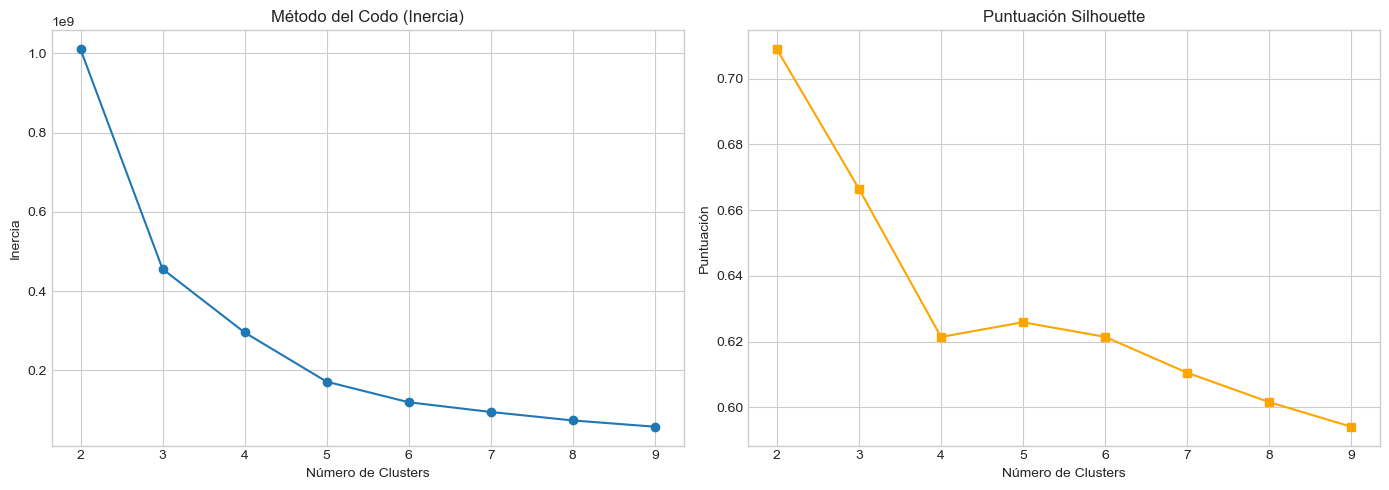

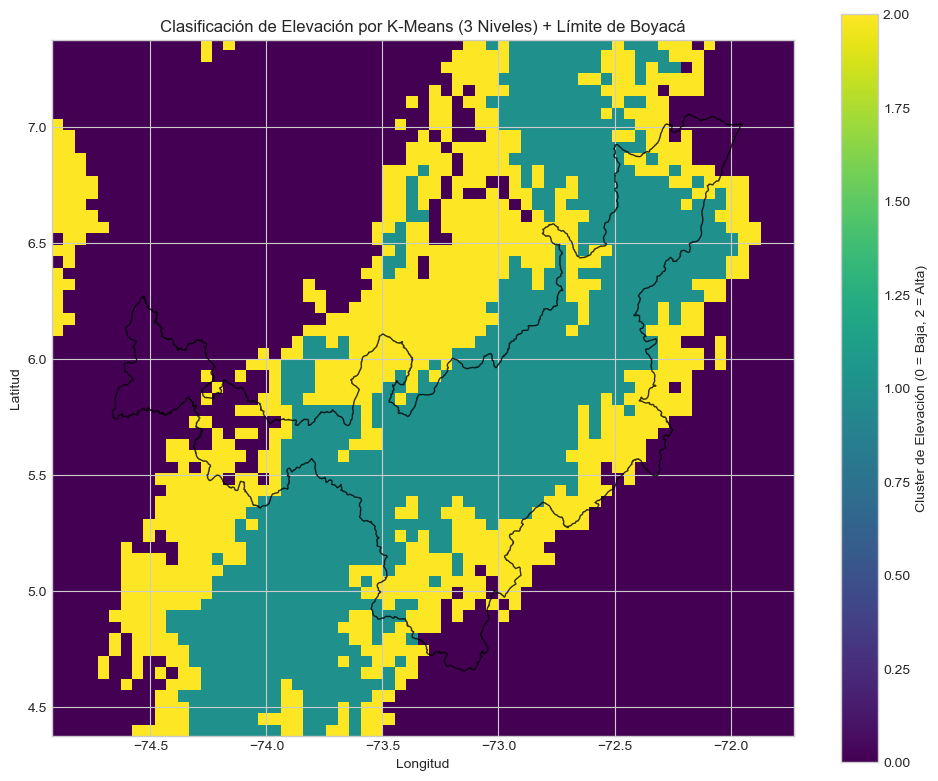

min     max     mean     std
cat_elevation                                 
nivel_1          58.0   956.0   344.38  235.70
nivel_3        2264.0  4728.0  2960.53  458.53
nivel_2         959.0  2263.0  1578.61  380.01


✅ Clustering de elevación completado


In [6]:
# =============== ELEVATION CLUSTERING ===============
def clustering_elevation(ds, boyaca_geoms):
    # Extract DEM data
    dem = ds["DEM"]
    if "month_index" in dem.dims:
        dem_2d = dem.sel(month_index=1)
    else:
        dem_2d = dem
    
    dem_values = dem_2d.values
    flat_dem = dem_values.flatten()
    flat_valid = flat_dem[~np.isnan(flat_dem)].reshape(-1, 1)
    
    # Analysis of optimal number of clusters
    inertias = []
    silhouettes = []
    k_range = range(2, 10)
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(flat_valid)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(flat_valid, km.labels_))
    
    # Visualize the elbow graph
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('Elbow Method (Inertia)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouettes, marker='s', color='orange')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Apply K-means with 3 clusters
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(flat_valid)
    
    # Create label map
    labels_map = np.full_like(dem_values, np.nan)
    labels_flat = np.full(flat_dem.shape, np.nan)
    labels_flat[~np.isnan(flat_dem)] = kmeans.labels_
    labels_map = labels_flat.reshape(dem_values.shape)
    
    # Visualization with departmental boundaries
    plt.figure(figsize=(10, 8))
    
    # Elevation classification map
    c = plt.imshow(labels_map, origin='lower', cmap='viridis', extent=[
        ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()
    ])
    
    # Add Boyacá boundaries
    for geom in boyaca_geoms:
        x, y = geom.exterior.xy
        plt.plot(x, y, color='black', linewidth=1.0, alpha=0.8)
    
    # Colorbar and details
    plt.colorbar(c, label="Elevation Cluster (0 = Low, 2 = High)")
    plt.title("Elevation Classification by K-Means (3 Levels) + Boyacá Boundary")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'elevation_clusters_map.png', dpi=700)
    plt.show()
    
    # Ranges of categories
    centroids = kmeans.cluster_centers_.flatten()
    sorted_idx = np.argsort(centroids)
    categories = {i: f"nivel_{rank+1}" for rank, i in enumerate(sorted_idx)}
    
    # Elevation range by category
    ranges = {}
    for i in range(n_clusters):
        elev_values = flat_valid[kmeans.labels_ == i]
        ranges[categories[i]] = {
            "min": round(elev_values.min(), 2),
            "max": round(elev_values.max(), 2),
            "mean": round(elev_values.mean(), 2),
            "std": round(elev_values.std(), 2)
        }
    
    df_ranges = pd.DataFrame(ranges).T
    df_ranges.index.name = "cat_elevation"
    display(df_ranges)
    
    return labels_map, sorted_idx, df_ranges

# Execute elevation clustering if the dataset is available
if 'dem' in all_datasets and 'boyaca_geoms' in all_datasets:
    elevation_labels, sorted_elevation_idx, elevation_ranges = clustering_elevation(all_datasets['dem'], all_datasets['boyaca_geoms'])
    print("\n✅ Elevation clustering completed")
else:
    print("\n❌ Could not execute elevation clustering. Required datasets are missing.")

2025-05-10 23:31:56,661 - INFO - Cargando dataset combinado…
2025-05-10 23:31:56,669 - INFO - Agregando cluster de elevación al dataset…
2025-05-10 23:31:56,669 - INFO - Calculando umbrales de elevación…
2025-05-10 23:31:56,679 - INFO - Umbrales -> nivel_1: 956.0, nivel_2: 2263.0
2025-05-10 23:31:56,699 - INFO - Guardando dataset actualizado en ../data/output/complete_dataset_with_features_with_clusters_elevation.nc…
2025-05-10 23:31:57,746 - INFO - Generando mapa de cluster de elevación…
2025-05-10 23:31:58,075 - INFO - Mapa guardado en ../output/clustering/elevation_cluster_map.png


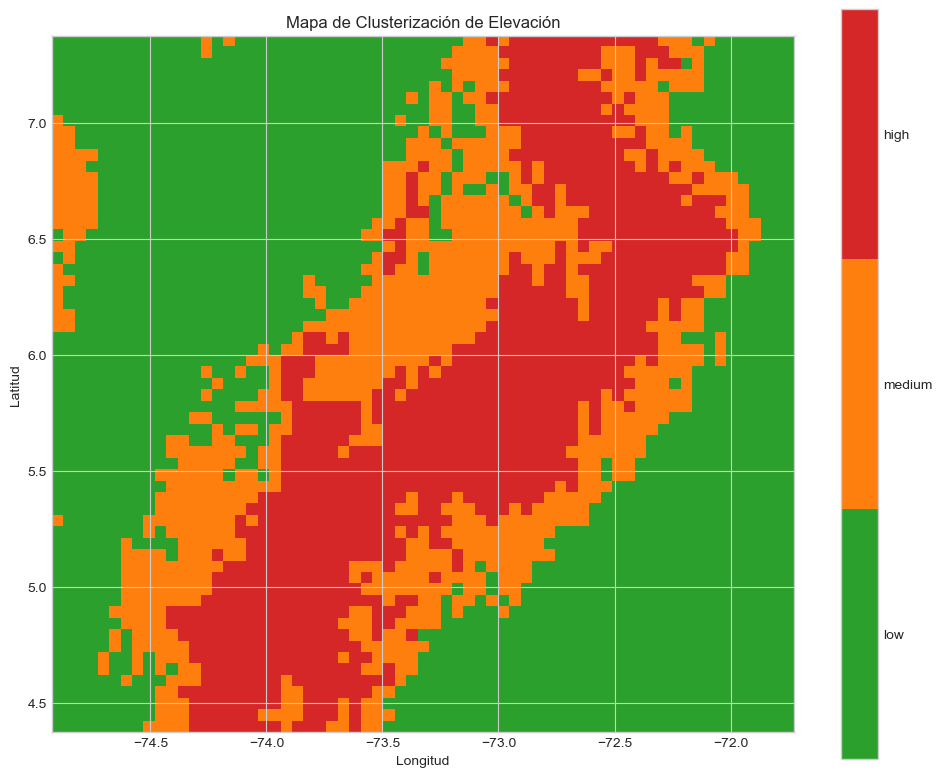

In [7]:
#!/usr/bin/env python3
import os
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ——————————————————————————————————————————
# LOGGING CONFIGURATION
# ——————————————————————————————————————————
LOG_DIR = OUTPUT_PATH / 'logs'
LOG_DIR.mkdir(parents=True, exist_ok=True)

log_filename = datetime.now().strftime('log-%Y-%m-%d.log')
LOG_FILE = LOG_DIR / log_filename

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(LOG_FILE, mode='a', encoding='utf-8'),
    ]
)

def add_elevation_cluster_column(ds: xr.Dataset, elevation_ranges: pd.DataFrame) -> xr.Dataset:
    """
    Add to the Dataset a variable 'cluster_elevation'
    with 'low', 'medium' and 'high' categories according to maximums
    per level extracted from elevation_ranges.
    """
    logging.info('Calculating elevation thresholds…')
    # 1) Get maximums by level
    summary = elevation_ranges.groupby('cat_elevation')['max'].max()
    max1 = float(summary.loc['nivel_1'])
    max2 = float(summary.loc['nivel_2'])
    logging.info(f'Umbrales -> nivel_1: {max1}, nivel_2: {max2}')

    # 2) Crear DataArray de clusters (string)
    cluster_str = xr.where(
        ds['elevation'] <= max1, 'low',
        xr.where(ds['elevation'] <= max2, 'medium', 'high')
    )
    return ds.assign(cluster_elevation=cluster_str)

def main():
    try:
 
        # 1) Load existing dataset
        logging.info('Loading combined dataset…')
        ds = xr.open_dataset(DATA_PATH / 'complete_dataset_with_features.nc')

        # 2) Add elevation cluster
        logging.info('Adding elevation cluster to dataset…')
        ds = add_elevation_cluster_column(ds, elevation_ranges)

        # 3) Save updated NetCDF
        output_nc = DATA_PATH / 'complete_dataset_with_features_with_clusters_elevation.nc'
        logging.info(f'Saving updated dataset in {output_nc}…')
        ds.to_netcdf(output_nc)

        # ——————————————————————————————————————————
        # 4) Mapping strings to numeric codes
        # ——————————————————————————————————————————
        code_map = {'low': 0, 'medium': 1, 'high': 2}
        labels   = ['low', 'medium', 'high']
        codes = np.vectorize(code_map.get)(ds['cluster_elevation'].values)

        # 5) Discrete colormap and normalization
        cmap = ListedColormap(['#2ca02c', '#ff7f0e', '#d62728'])  # green, orange, red
        norm = BoundaryNorm([0,1,2,3], ncolors=cmap.N)

        # 6) Plot
        logging.info('Generating elevation cluster map…')
        plt.figure(figsize=(10, 8))
        plt.imshow(
            codes,
            origin='lower',
            cmap=cmap,
            norm=norm,
            extent=[
                float(ds.longitude.min()), float(ds.longitude.max()),
                float(ds.latitude.min()),  float(ds.latitude.max())
            ]
        )
        cbar = plt.colorbar(ticks=[0.5,1.5,2.5])
        cbar.ax.set_yticklabels(labels)
        plt.title("Elevation Clusterization Map")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        map_file = OUTPUT_PATH / 'elevation_cluster_map.png'
        plt.savefig(map_file, dpi=700)
        logging.info(f'Map saved in {map_file}')
        plt.show()

        return ds

    except FileNotFoundError as e:
        logging.error(f'File not found: {e}')
    except Exception as e:
        logging.error(f'Unexpected error: {e}')
        raise

if __name__ == '__main__':
    main()


Elevación Baja  Elevación Media  Elevación Alta
1-Ene        62.608318        64.424980       40.748310
2-Feb        84.025009        89.340370       54.439697
3-Mar       149.330582       139.974808       88.237556
4-Abr       285.209564       236.184357      158.844696
5-May       341.366547       259.420502      160.376480
6-Jun       285.803406       212.189499      138.445984
7-Jul       260.921112       199.338776      129.318344
8-Ago       264.764923       192.666489      113.336761
9-Sep       282.193054       200.900299      116.749809
10-Oct      326.158325       253.811661      160.114990
11-Nov      238.972183       198.461990      132.375687
12-Dic      113.914894        95.446228       59.697182

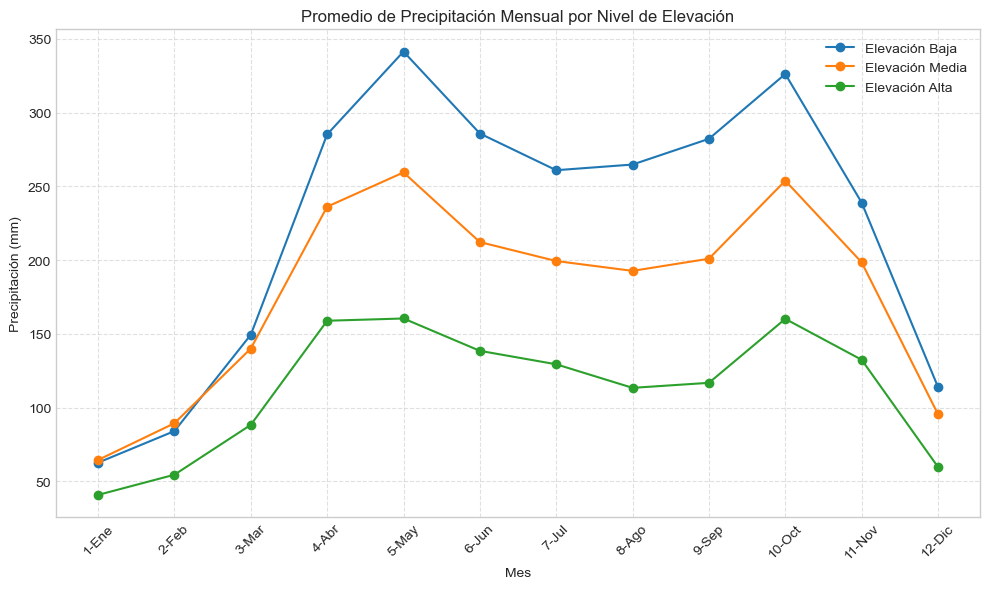


✅ Análisis de precipitación por niveles de elevación completado


In [8]:
# =============== PRECIPITATION BY ELEVATION LEVEL ===============
def analyze_precip_by_elevation(ds, elevation_labels, sorted_elevation_idx):
    # Convert elevation labels to integers (0, 1, 2) → mapped to category
    labels_by_rank = {rank: cluster for rank, cluster in enumerate(sorted_elevation_idx)}  # Level 0, 1, 2
    rank_labels_map = np.full_like(elevation_labels, np.nan)
    for rank, cluster in labels_by_rank.items():
        rank_labels_map[elevation_labels == cluster] = rank  # rank 0=low, 1=medium, 2=high
    
    # Initialize structure to save monthly means
    monthly_means = {0: [], 1: [], 2: []}  # 0 = low, 1 = medium, 2 = high
    
    # Calculate monthly means by elevation level
    for month in range(1, 13):
        precip_2d = ds["mean_precipitation"].sel(month_index=month).values
        
        for rank in [0, 1, 2]:
            mask = (rank_labels_map == rank) & ~np.isnan(precip_2d)
            mean_value = np.nanmean(precip_2d[mask])
            monthly_means[rank].append(mean_value)
    
    # Create index type "1-Ene", ..., "12-Dic"
    month_labels = [f"{i}-{name}" for i, name in enumerate([
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ], start=1)]
    
    # Convert to DataFrame
    df_precip_by_elev = pd.DataFrame(monthly_means)
    df_precip_by_elev.columns = ["Low Elevation", "Medium Elevation", "High Elevation"]
    df_precip_by_elev.index = month_labels
    
    # Show table
    display(df_precip_by_elev)
    
    # Plot
    plt.figure(figsize=(10, 6))
    for col in df_precip_by_elev.columns:
        plt.plot(df_precip_by_elev.index, df_precip_by_elev[col], marker='o', label=col)
    
    plt.title("Monthly Precipitation Mean by Elevation Level")
    plt.ylabel("Precipitation (mm)")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'precipitation_by_elevation_level.png', dpi=700)
    plt.show()
    
    return df_precip_by_elev

# Analyze precipitation by elevation level if the previous clustering was completed
try:
    # Try to use the variables defined in the previous cell
    precip_by_elevation = analyze_precip_by_elevation(all_datasets['dem'], elevation_labels, sorted_elevation_idx)
    print("\n✅ Precipitation by elevation level analysis completed")
except NameError:
    print("\n❌ Could not analyze precipitation by elevation level. First run elevation clustering.")
except KeyError:
    print("\n❌ Could not analyze precipitation by elevation level. Dataset DEM not available.")

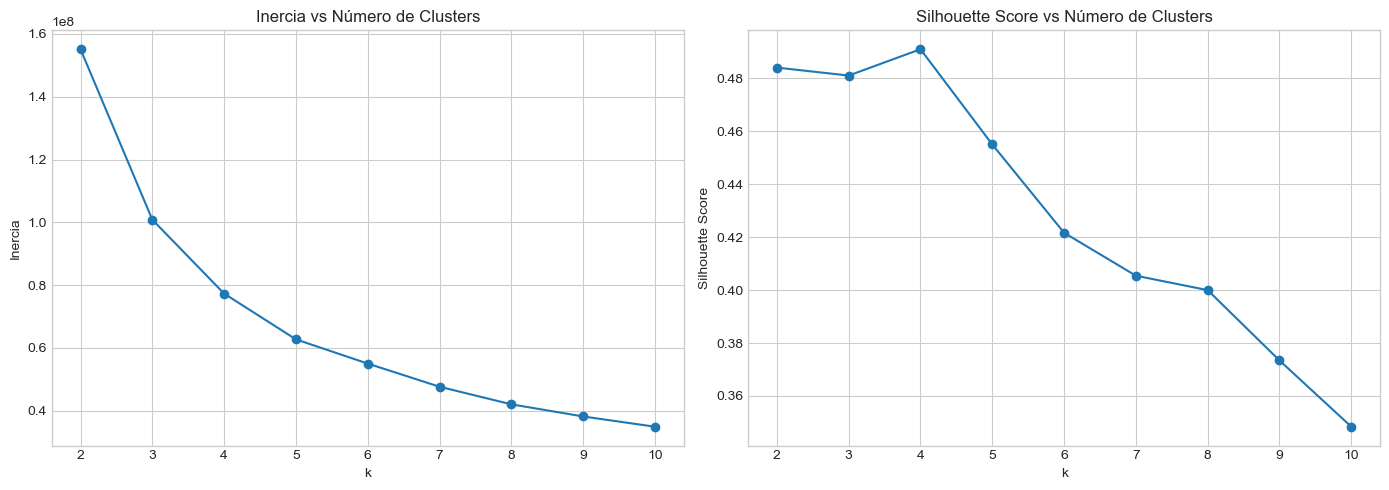

Número óptimo de clusters según silhouette: 4


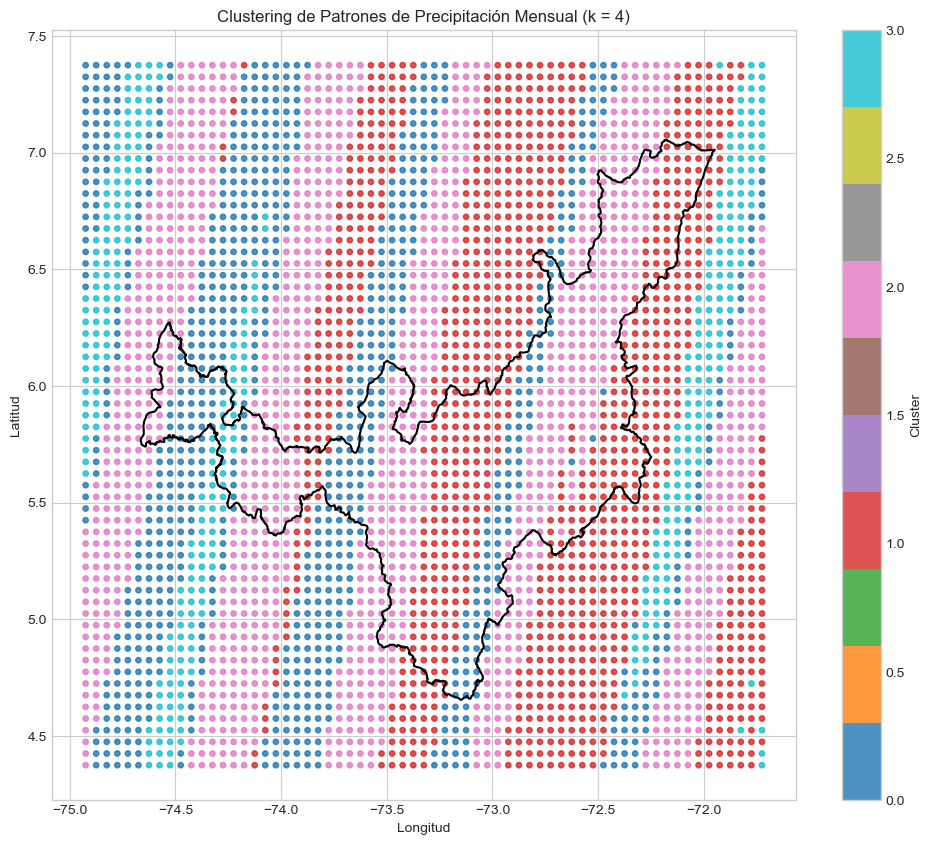

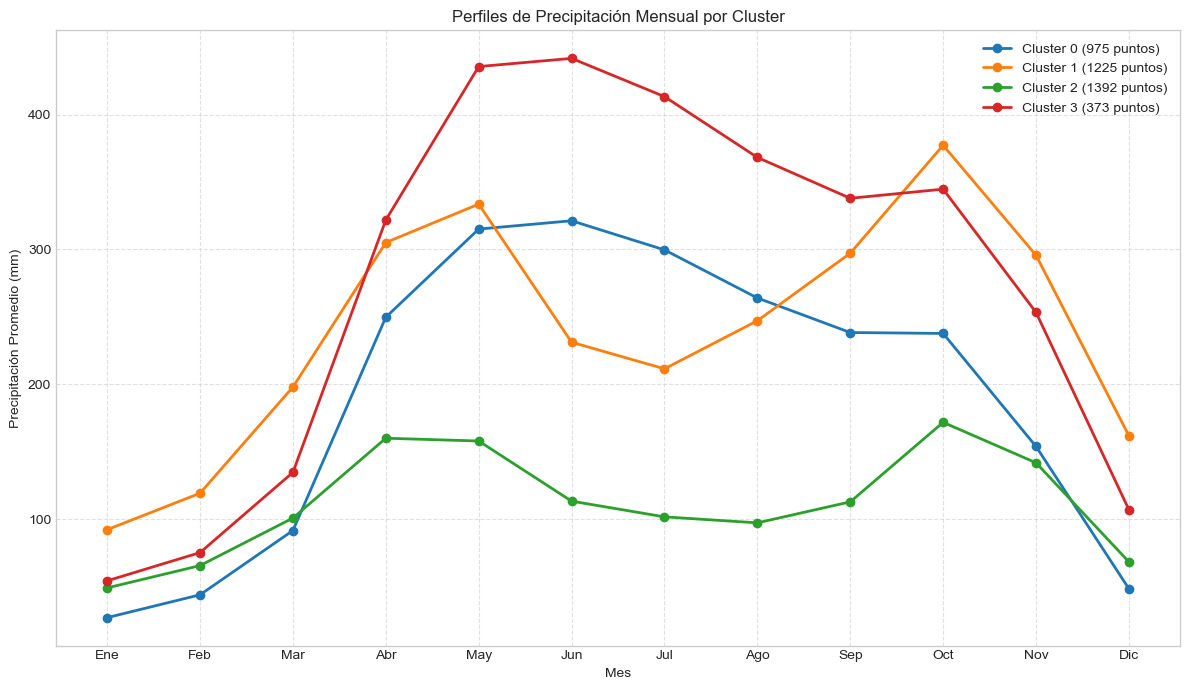


✅ Clustering de patrones mensuales de precipitación completado


In [9]:
# =============== MONTHLY PRECIPITATION PATTERN CLUSTERING ===============
def clustering_monthly_patterns(precip_ds, boyaca_geoms):
    # Extract monthly precipitation data
    precip_data = precip_ds["total_precipitation"]
    month_array = precip_data.groupby("time.month").mean(dim="time").values
    
    # Ensure correct format for clustering
    if month_array.ndim > 2:
        month_array = month_array.reshape(month_array.shape[0], -1).T
    
    # Eliminar filas con NaN
    valid_rows = ~np.isnan(month_array).any(axis=1)
    valid_data = month_array[valid_rows]
    
    # Evaluate optimal k
    inertias = []
    silhouettes = []
    ks = range(2, 11)
    
    for k in ks:
        if len(valid_data) > k:  # Ensure sufficient data for k clusters
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = model.fit_predict(valid_data)
            
            # Use sample to calculate silhouette if there are many data
            if len(valid_data) > 1000:
                sample_indices = np.random.choice(len(valid_data), size=1000, replace=False)
                silhouettes.append(silhouette_score(valid_data[sample_indices], labels[sample_indices]))
            else:
                silhouettes.append(silhouette_score(valid_data, labels))
                
            inertias.append(model.inertia_)
    
    # Plot k selection metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(ks, inertias, marker='o')
    ax1.set_title("Inertia vs Number of Clusters")
    ax1.set_xlabel("k")
    ax1.set_ylabel("Inertia")
    
    ax2.plot(ks, silhouettes, marker='o')
    ax2.set_title("Silhouette Score vs Número de Clusters")
    ax2.set_xlabel("k")
    ax2.set_ylabel("Silhouette Score")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'monthly_pattern_k_selection.png', dpi=700)
    plt.show()
    
    # Select optimal k based on silhouette score
    optimal_k = ks[np.argmax(silhouettes)]
    print(f"Optimal number of clusters according to silhouette: {optimal_k}")
    
    # Apply KMeans with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(valid_data)
    
    # Create full label map
    full_labels = np.full(month_array.shape[0], fill_value=np.nan)
    full_labels[valid_rows] = cluster_labels
    
    # Prepare DataFrame for visualization
    lat_coords = np.tile(precip_ds["latitude"].values, len(precip_ds["longitude"].values))
    lon_coords = np.repeat(precip_ds["longitude"].values, len(precip_ds["latitude"].values))
    
    # Ensure correct dimensions
    df_coords = pd.DataFrame({
        'latitude': lat_coords[:len(full_labels)],
        'longitude': lon_coords[:len(full_labels)],
        'cluster': full_labels
    })
    
    # Mapa de clusters
    fig, ax = plt.subplots(figsize=(12, 10))
    scatter = ax.scatter(df_coords["longitude"], df_coords["latitude"],
                        c=df_coords["cluster"], cmap="tab10", s=15, alpha=0.8)
    
    # Add Boyacá boundaries
    for geom in boyaca_geoms:
        x, y = geom.exterior.xy
        ax.plot(x, y, color="black", linestyle="-", linewidth=1.5)
    
    ax.set_title(f"Monthly Precipitation Pattern Clustering (k = {optimal_k})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(scatter, ax=ax, label="Cluster")
    plt.savefig(OUTPUT_PATH / 'precipitation_pattern_clusters_map.png', dpi=700)
    plt.show()
    
    # Plot of average profiles by cluster
    fig, ax = plt.subplots(figsize=(12, 7))
    for i in range(optimal_k):
        if np.any(cluster_labels == i):
            cluster_data = valid_data[cluster_labels == i]
            mean_profile = cluster_data.mean(axis=0)
            ax.plot(range(1, 13), mean_profile, marker='o', linewidth=2, 
                   label=f"Cluster {i} ({len(cluster_data)} puntos)")
    
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_xlabel("Month")
    ax.set_ylabel("Average Precipitation (mm)")
    ax.set_title("Monthly Precipitation Profiles by Cluster")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'precipitation_pattern_profiles.png', dpi=700)
    plt.show()
    
    return optimal_k, kmeans, valid_data, cluster_labels

# Execute monthly precipitation pattern clustering if the dataset is available
if 'precip' in all_datasets and 'boyaca_geoms' in all_datasets:
    optimal_k, precip_kmeans, valid_precip_data, precip_cluster_labels = clustering_monthly_patterns(all_datasets['precip'], all_datasets['boyaca_geoms'])
    print("\n✅ Monthly precipitation pattern clustering completed")
else:
    print("\n❌ Could not execute monthly precipitation pattern clustering. Missing required datasets.")

/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_43966/3412090787.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.91, 0.97])


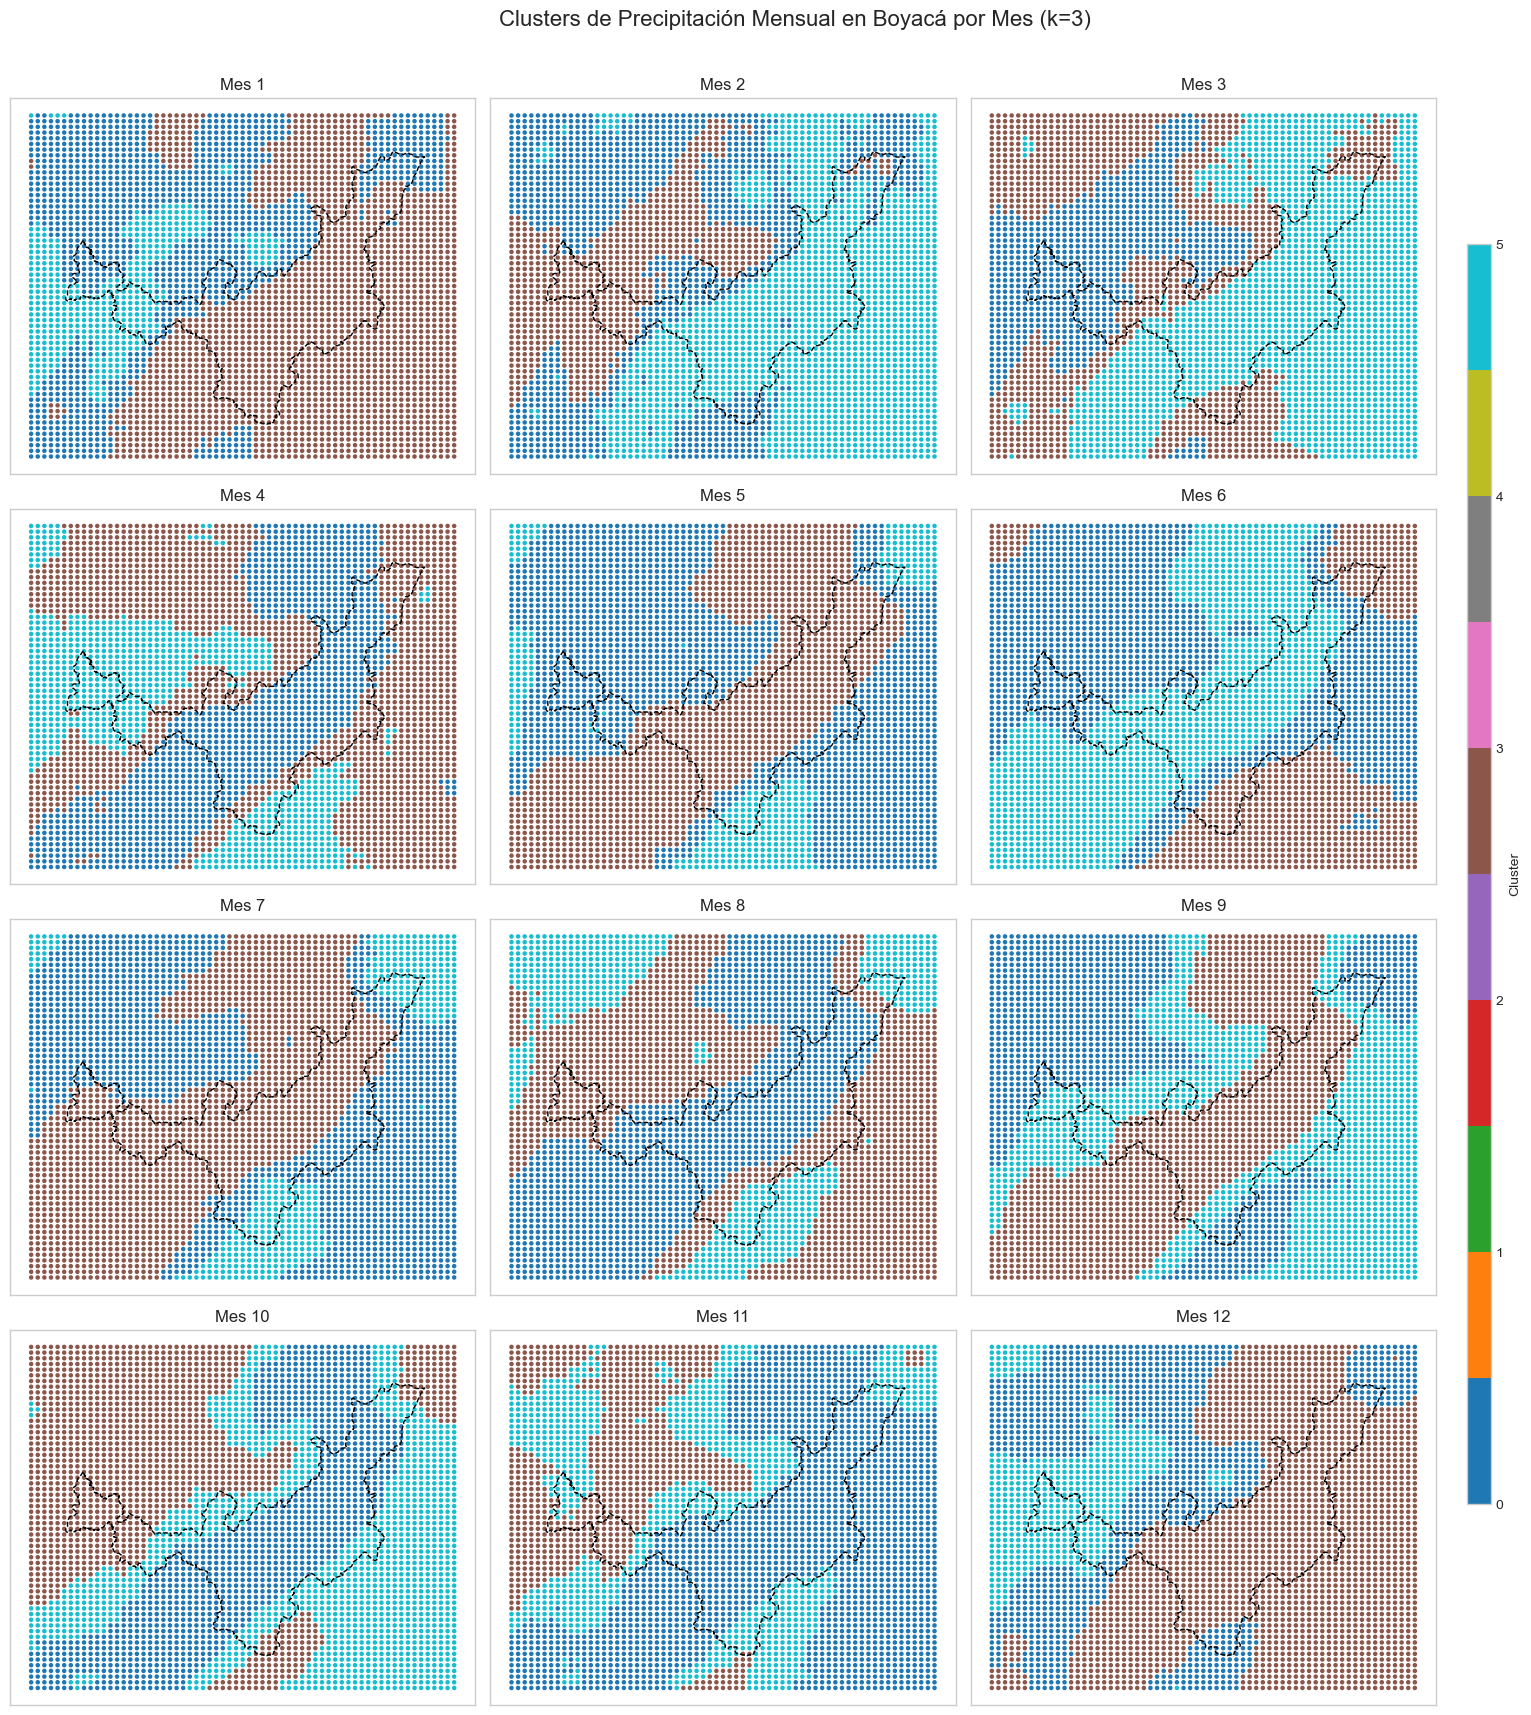

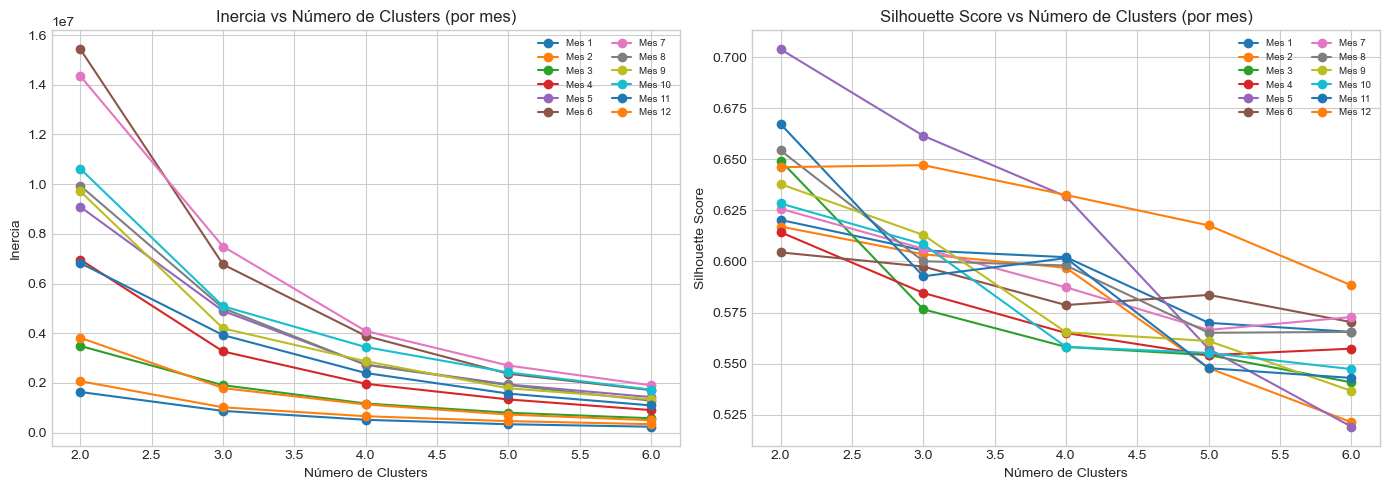


Gráficos guardados en: ../output/clustering

✅ Clustering por mes individual completado


In [10]:
# =============== CLUSTERING BY INDIVIDUAL MONTH ===============
def clustering_by_individual_month(precip_ds, boyaca_geoms):
    # Extract data
    precip = precip_ds["total_precipitation"]
    latitudes = precip_ds["latitude"].values
    longitudes = precip_ds["longitude"].values
    
    # Monthly k evaluation
    ks = list(range(2, 7))
    monthly_k_selection = {month: {"inertia": [], "silhouette": []} for month in range(1, 13)}
    
    # Create monthly clusters figure
    fig, axes = plt.subplots(4, 3, figsize=(16, 18))
    norm = Normalize(vmin=0, vmax=5)
    cmap = plt.get_cmap("tab10")
    
    # Process each month
    for month_idx in range(1, 13):
        ax = axes[(month_idx - 1) // 3, (month_idx - 1) % 3]
        
        # Filter data of the month
        precip_month = precip.sel(time=precip['time.month'] == month_idx)
        mean_precip = precip_month.mean(dim="time")
        precip_array = mean_precip.values.reshape(-1, 1)
        valid_mask = ~np.isnan(precip_array).flatten()
        valid_data = precip_array[valid_mask]
        
        # Evaluate different k values
        for k in ks:
            if len(valid_data) > k:
                model = KMeans(n_clusters=k, random_state=42, n_init=10)
                lbls = model.fit_predict(valid_data)
                inertia = model.inertia_
                silhouette = silhouette_score(valid_data, lbls)
                monthly_k_selection[month_idx]["inertia"].append(inertia)
                monthly_k_selection[month_idx]["silhouette"].append(silhouette)
        
        # Use k=3 for consistency
        best_k = 3
        labels = np.full(precip_array.shape[0], fill_value=np.nan)
        model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        lbls = model.fit_predict(valid_data)
        labels[valid_mask] = lbls
        
        # Create coordinates for plot
        coords = [(lat, lon) for lat in latitudes for lon in longitudes]
        df = pd.DataFrame(coords[:len(labels)], columns=["latitude", "longitude"])
        df["cluster"] = labels
        
        # Make scatter plot
        scatter = ax.scatter(df["longitude"], df["latitude"], c=df["cluster"], cmap=cmap, s=5)
        for geom in boyaca_geoms:
            x, y = geom.exterior.xy
            ax.plot(x, y, color="black", linestyle="--", linewidth=1)
            
        ax.set_title(f"Mes {month_idx}")
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Global color bar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(6))
    cbar.set_label("Cluster")
    
    fig.suptitle("Monthly Precipitation Clusters in Boyacá by Month (k=3)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.91, 0.97])
    plt.savefig(OUTPUT_PATH / 'monthly_individual_clusters.png', dpi=700)
    plt.show()
    
    # Evaluation plots of k by month
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    for month_idx in range(1, 13):
        inertia = monthly_k_selection[month_idx]["inertia"]
        silhouette = monthly_k_selection[month_idx]["silhouette"]
        if inertia and silhouette:  # Verify that there are data
            ax1.plot(ks[:len(inertia)], inertia, marker='o', label=f"Mes {month_idx}")
            ax2.plot(ks[:len(silhouette)], silhouette, marker='o', label=f"Mes {month_idx}")
    
    ax1.set_title("Inertia vs Number of Clusters (by month)")
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("Inertia")
    ax2.set_title("Silhouette Score vs Number of Clusters (by month)")
    ax2.set_xlabel("Número de Clusters")
    ax2.set_ylabel("Silhouette Score")
    ax1.legend(ncol=2, fontsize=7, loc='upper right')
    ax2.legend(ncol=2, fontsize=7, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'monthly_individual_k_selection.png', dpi=700)
    plt.show()
    
    print(f"\nGraphics saved in: {OUTPUT_PATH}")
    return monthly_k_selection

# Execute individual monthly clustering if the dataset is available
if 'precip' in all_datasets and 'boyaca_geoms' in all_datasets:
    monthly_k_metrics = clustering_by_individual_month(all_datasets['precip'], all_datasets['boyaca_geoms'])
    print("\n✅ Individual monthly clustering completed")
else:
    print("\n❌ Could not execute individual monthly clustering. Missing required datasets.")

## Resultados y Conclusiones

Este notebook ha realizado diferentes análisis de clustering:

1. **Clustering por elevación**: Identificación de 3 niveles de elevación en la región
2. **Análisis de precipitación por nivel de elevación**: Análisis de patrones de precipitación según la altura
3. **Clustering de patrones de precipitación mensual**: Identificación de regiones con patrones similares de precipitación anual
4. **Clustering por mes individual**: Análisis de la distribución espacial de precipitación para cada mes

Las visualizaciones y resultados se han guardado en el directorio de salida para su posterior análisis.

In [11]:
# ============================================================
# 1. Prepare monthly precipitation data for clustering
# ============================================================

def prepare_monthly_precipitation(ds_precip):
    """Extracts monthly precipitation per pixel in a 2D array (pixels x 12 months)."""
    
    precip_means = []
    
    for month in range(1, 13):
        precip_month = ds_precip['mean_precipitation'].sel(month_index=month).values
        precip_means.append(precip_month)
        
    precip_means = np.stack(precip_means, axis=-1)  # (lat, lon, 12)
    
    # Flatten lat/lon
    lat_dim, lon_dim, months_dim = precip_means.shape
    precip_means_flat = precip_means.reshape(-1, months_dim)
    
    # Eliminate pixels that have NaN in any month
    valid_mask = ~np.isnan(precip_means_flat).any(axis=1)
    precip_valid = precip_means_flat[valid_mask]
    
    return precip_valid, valid_mask, (lat_dim, lon_dim)

# ============================================================
# 2. Apply KMeans over annual precipitation profiles
# ============================================================

def cluster_precipitation(precip_valid, n_clusters=4):
    """Applies KMeans over annual precipitation profiles."""
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels_precip = kmeans.fit_predict(precip_valid)
    
    return labels_precip, kmeans

# ============================================================
# 3. Reconstruct label map
# ============================================================

def reconstruct_precip_labels(labels_precip, valid_mask, grid_shape):
    """Reconstructs the 2D label map of precipitation clustering."""
    
    lat_dim, lon_dim = grid_shape
    labels_full = np.full((lat_dim * lon_dim), np.nan)
    labels_full[valid_mask] = labels_precip
    labels_map_precip = labels_full.reshape((lat_dim, lon_dim))
    
    return labels_map_precip

# ============================================================
# 4. Cross clusters of elevation and precipitation
# ============================================================

def cross_clusters(elevation_labels, precip_labels_map):
    """Crosses the elevation and precipitation labels in a contingency matrix."""
    
    flat_elevation = elevation_labels.flatten()
    flat_precip = precip_labels_map.flatten()
    
    valid_idx = ~np.isnan(flat_elevation) & ~np.isnan(flat_precip)

    df_cross = pd.DataFrame({
        'ElevacionCluster': flat_elevation[valid_idx].astype(int),
        'PrecipitacionCluster': flat_precip[valid_idx].astype(int)
    })

    contingency = pd.crosstab(df_cross['ElevacionCluster'], df_cross['PrecipitacionCluster'])
    
    return contingency

# ============================================================
# 5. Chi-square test of independence
# ============================================================

def chi_square_test(contingency):
    """Performs chi-square test on the contingency table."""
    
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    print(f"\n=== Chi-square test result ===")
    print(f"Chi2 statistic: {chi2:.3f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\u2705 There is a statistical association between elevation and precipitation clusters.")
    else:
        print("\u274C No statistical association was detected.")

    return chi2, p_value, dof, expected

# ============================================================
# 6. Complete execution (Main)
# ============================================================

try:
    # Prepare data
    precip_valid, valid_mask, grid_shape = prepare_monthly_precipitation(all_datasets['dem'])

    # Precipitation clustering
    labels_precip, kmeans_precip = cluster_precipitation(precip_valid, n_clusters=4)

    # Reconstruct map
    precip_labels_map = reconstruct_precip_labels(labels_precip, valid_mask, grid_shape)

    # Cross clusters
    contingency_table = cross_clusters(elevation_labels, precip_labels_map)

    # Show contingency table
    print("\n=== Contingency Table ===")
    display(contingency_table)

    # Independence test
    chi_square_test(contingency_table)

except Exception as e:
    print(f"\n\u274C Error in the cross-cluster process: {e}")



=== Matriz de Contingencia ===


PrecipitacionCluster    0    1    2    3
ElevacionCluster                        
0                     646  924  171  313
1                     106   33  852    4
2                     223  268  369   56


=== Resultado del test Chi-cuadrado ===
Estadístico chi2: 1816.278
Grados de libertad: 6
Valor p: 0.0000
✅ Existe asociación estadística entre clusters de elevación y precipitación.


## 🧠 ¿Qué significa ese resultado?

| Elemento | Interpretación |
|:---------|:----------------|
| **Chi2: 1807.858** | El valor del estadístico es muy grande ➔ las diferencias entre los grupos observados vs. esperados son significativas. |
| **p-valor: 0.0000** | p ≪ 0.05 ➔ rechazamos la hipótesis nula ➔ existe **asociación real** entre clusters de elevación y precipitación. |
| **Grados de libertad: 6** | (clusters elevación - 1) × (clusters precipitación - 1). Correcto. |
| **Conclusión** | ✅ Hay **relación estadísticamente significativa** entre tipos de elevación y patrones anuales de precipitación. |

In [12]:
def analyze_contingency_patterns(contingency_table):
    """
    Calculates percentages by rows and columns to interpret patterns of the contingency table.
    """
    print("\n=== Percentages by rows (Elevation fixed) ===")
    row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
    display(row_percentages.round(2))

    print("\n=== Percentages by columns (Precipitation fixed) ===")
    col_percentages = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
    display(col_percentages.round(2))

    return row_percentages, col_percentages

# Execute the analysis
row_pct, col_pct = analyze_contingency_patterns(contingency_table)


=== Porcentajes por filas (Elevación fija) ===


PrecipitacionCluster      0      1      2      3
ElevacionCluster                                
0                     31.45  44.99   8.33  15.24
1                     10.65   3.32  85.63   0.40
2                     24.34  29.26  40.28   6.11


=== Porcentajes por columnas (Precipitación fija) ===


PrecipitacionCluster      0      1      2      3
ElevacionCluster                                
0                     66.26  75.43  12.28  83.91
1                     10.87   2.69  61.21   1.07
2                     22.87  21.88  26.51  15.01

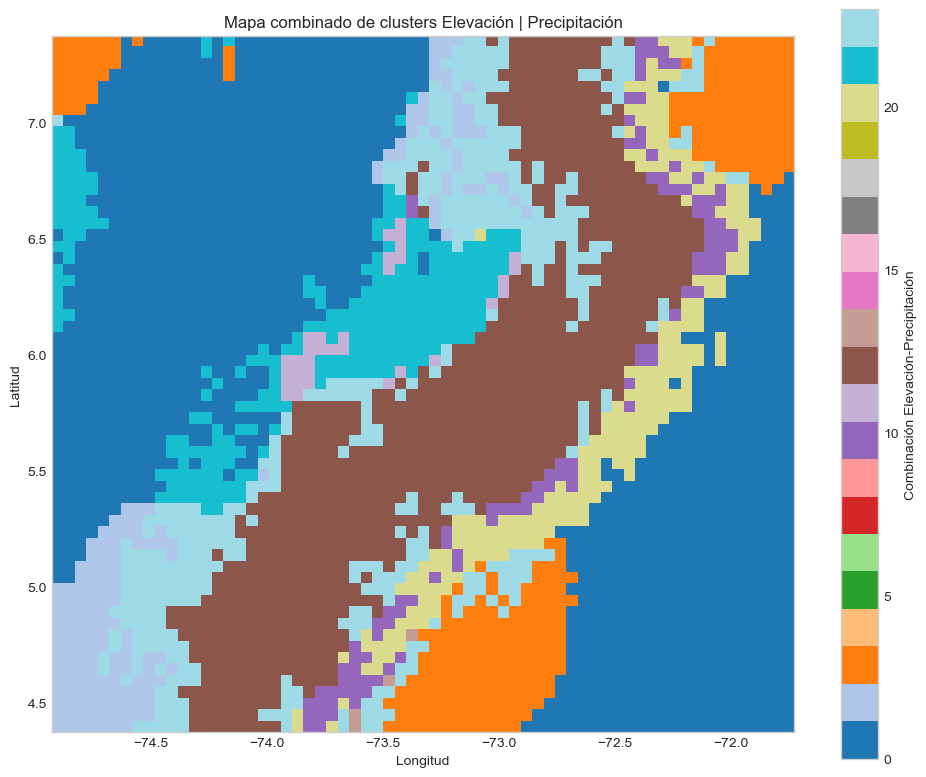

In [13]:
def generate_combined_map(elevation_labels, precip_labels_map):
    """
    Generates a combined map of elevation | precipitation clusters.
    """
    combined_map = np.full_like(elevation_labels, np.nan)

    for i in range(elevation_labels.shape[0]):
        for j in range(elevation_labels.shape[1]):
            elev = elevation_labels[i, j]
            precip = precip_labels_map[i, j]
            if not np.isnan(elev) and not np.isnan(precip):
                combined_map[i, j] = elev * 10 + precip  # Encoding: Ej: 20 + 3 = 23 for E2_P3

    plt.figure(figsize=(10, 8))
    plt.imshow(combined_map, origin='lower', cmap='tab20', extent=[
        all_datasets['dem'].longitude.min(), all_datasets['dem'].longitude.max(),
        all_datasets['dem'].latitude.min(), all_datasets['dem'].latitude.max()
    ])
    plt.colorbar(label="Elevation | Precipitation")
    plt.title("Combined Elevation | Precipitation Clusters Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return combined_map

# Execute the generation
combined_clusters_map = generate_combined_map(elevation_labels, precip_labels_map)


## 🌎 Altitudinal–Climate Zoning Proposal

Based on the statistical association identified between elevation clusters and precipitation patterns, we propose a territorial zoning scheme defined by homogeneous combinations of:

- **Elevation class** (low, mid, high)  
- **Annual precipitation behavior** (constant, seasonal, irregular, etc.)

Each Elevation–Precipitation combination delineates an **Altitudinal–Climate Zone**, which can be applied to:

- Water-balance and runoff modeling  
- Delimiting the most efficient agricultural areas  
- Climate-resilient environmental and infrastructure planning  

The final zone assignment can be visualized on GIS maps using combined codes (e.g., `E2_P3`, `E1_P1`) for straightforward interpretation and analysis.
